This script use ta extraction and random forest to select the features, unify the data using MinMaxScaler, and then input the remaining feature paralelly into a simple
LSTM model.

In [1]:
import sys
import pandas as pd
import torch

sys.path.append('..')
from utils import add_STL
from data_feature_extraction.CoT_Dissa import extract_data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

c:\Users\lqs\miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

## Config for this model:
### extract and filter
nCorrTop: num of Corr filter size
nMICTop: num of MIC filter size
### STL decomposition
period
seasonal (>= 3 and odd)
### Ramdom forest
n_estimators = 100
random_state = 42
### datasplit
test_size
### training

num_epochs = 120

lr = 0.008

batch_size = 32

l = 24

pr = 1 (Length of predict)

Loss function 
### LTSM with positional encoder
hidden_dim = 128
output_dim = pr
num_layers = 2

In [2]:
df = extract_data(datasoursepath = '../data/GC=F_com_disagg.csv', finalextracteddatapath = '../data/GC=F_com_disagg_finalextracted.csv', nCorrTop=100, nMICTop= 70)

ouput file already exsist, just read this file


Extract OHLC from trend and fluctuation
Calculate MA and fluctuation for training data for OHLC. put all data as new columns, and interpolate all beginning data with future data.

In [3]:
df = add_STL(df, period=20, seasonal = 5)
# df

In [4]:
string_cols = df.select_dtypes(include=['object']).columns.tolist()
df.set_index('date', drop=True)
print(len(df.columns))
print(df.columns)

87
Index(['date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Market_and_Exchange_Names', 'Report_Date_as_YYYY-MM-DD',
       'CFTC_Market_Code', 'Open_Interest_All', 'Prod_Merc_Positions_Long_All',
       'Prod_Merc_Positions_Short_All', 'Swap_Positions_Long_All',
       'Swap__Positions_Short_All', 'Swap__Positions_Spread_All',
       'M_Money_Positions_Long_All', 'M_Money_Positions_Short_All',
       'M_Money_Positions_Spread_All', 'Other_Rept_Positions_Long_All',
       'Other_Rept_Positions_Short_All', 'Other_Rept_Positions_Spread_All',
       'NonRept_Positions_Long_All', 'NonRept_Positions_Short_All',
       'Change_in_Open_Interest_All', 'Change_in_Prod_Merc_Long_All',
       'Change_in_Prod_Merc_Short_All', 'Change_in_Swap_Long_All',
       'Change_in_Swap_Short_All', 'Change_in_Swap_Spread_All',
       'Change_in_M_Money_Long_All', 'Change_in_M_Money_Short_All',
       'Change_in_M_Money_Spread_All', 'Change_in_Other_Rept_Long_All',
       'Change_in_NonRep

Select the features

In [5]:
from data_feature_selection.cot_dissag import select_feature
test_size = 0.05
df_selected = select_feature(df, test_size= test_size, m = 10)

trend: 0.9806925046867152
Swap__Positions_Short_All: 0.010519838116900743
Open_Interest_All: 0.003010742972558681
resid: 0.0013783091155644453
seasonal: 0.0005638880832751236
volume_vwap: 0.00033226897268496657
M_Money_Positions_Long_All: 0.00032194629622819886
momentum_rsi: 0.00024135510731017258
volume_nvi: 0.0001681522016041086
trend_adx_neg: 0.00016754395895702049
Conc_Gross_LE_4_TDR_Long_All: 0.0001643438172679207
Pct_of_OI_Swap_Short_All: 0.00016125852351965558
NonRept_Positions_Short_All: 0.00013748343443237932
Change_in_Other_Rept_Long_All: 0.00011721915789615454
Conc_Net_LE_4_TDR_Long_All: 9.936278147504227e-05
volume_obv: 9.390974240880746e-05
trend_adx_pos: 9.372083801422387e-05
Pct_of_OI_M_Money_Long_All: 7.875365838516603e-05
Conc_Gross_LE_4_TDR_Short_All: 7.845144815374213e-05
volume_adi: 6.796488782584817e-05
Other_Rept_Positions_Short_All: 6.025140770263971e-05
Pct_of_OI_Prod_Merc_Long_All: 5.750622542599158e-05
volume_mfi: 5.5105809512287324e-05
Pct_of_OI_Other_Rept_Sp

Unifying all data using min max scaler

In [6]:

train_size = int((1 - test_size) * len(df_selected))  # Use first 80% of series as training data
# Apply the MinMaxScaler to the df_selected
train_df = df_selected.iloc[:train_size]
test_df = df_selected
print(train_df.columns)
print(test_df.describe())
print(test_df.head(20))

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'trend',
       'Swap__Positions_Short_All', 'Open_Interest_All', 'resid', 'seasonal',
       'volume_vwap', 'M_Money_Positions_Long_All', 'momentum_rsi',
       'volume_nvi', 'trend_adx_neg'],
      dtype='object')
              Open         High          Low        Close    Adj Close  \
count  2133.000000  2133.000000  2133.000000  2133.000000  2133.000000   
mean   1489.545476  1496.695219  1482.524145  1489.613971  1489.613971   
std     287.324062   289.384382   285.393846   287.434243   287.434243   
min    1053.699951  1062.000000  1046.199951  1050.800049  1050.800049   
25%    1246.300049  1249.900024  1240.000000  1246.099976  1246.099976   
50%    1338.099976  1344.199951  1332.599976  1338.699951  1338.699951   
75%    1787.099976  1794.099976  1778.800049  1785.300049  1785.300049   
max    2053.600098  2072.000000  2040.000000  2051.500000  2051.500000   

              Volume        trend  Swap__Positions_Shor

In [7]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Initialize a MinMaxScaler
scaler = MinMaxScaler()

def create_dataset(scaler: MinMaxScaler, df: pd.DataFrame, l, pr):
    """
    For train: Create dataset just for model training. It should be large in whole dataset.
    It will firstly do scaling on all cols (over whole input dataset), so make sure there is no string columns.
    For test: create test dataset. The set have lookback period and future date, 
    for the testing data should not contain future data, you need to  May be need to calculate rolling minmax for each input:
    it should keep moving and calculate all using.
    """
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    X, Y = [], []
    for i in range(len(df)-l-pr+1):
        X.append(df.iloc[i:i+l].values)  # Get the values for l days
        Y.append(df.iloc[i+l:i+l+pr]['Close'].values)  # Get the closing price for the 16th day
    return np.array(X), np.array(Y), scaler




In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 24
# Split the data into training and test sets


# Create the dataset
l = 32
pr = 5

# Create the dataset
train_X, train_Y, scaler = create_dataset(scaler,train_df, l, pr)
test_X, test_Y, scaler = create_dataset(scaler,test_df, l, pr)
test_X, test_Y= test_X[len(train_Y):], test_Y[len(train_Y):]
 
# Create TensorDatasets
train_data = TensorDataset(torch.from_numpy(train_X).to(torch.float32), torch.from_numpy(train_Y).to(torch.float32))
test_data = TensorDataset(torch.from_numpy(test_X).to(torch.float32), torch.from_numpy(test_Y).to(torch.float32))
# Create DataLoaders
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)



In [9]:
import torch.nn as nn

# Define LSTM network
class StockPredictor(nn.Module):
    """Implemented using LSTM and some dropout layer.
    
    Args:
        nn (_type_): _description_
    """
    def __init__(self, input_dim: int, hidden_dim: int, num_layers: int, output_dim: int, dropout_prob=0.1):
        super().__init__()
        self.hidden_size = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)  # Bidirectional LSTM
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_dim*2, output_dim)  # More dense layers
        # self.fc2 = nn.Linear(hidden_dim, output_dim) 

    def forward(self, x):
        
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size, device=x.device).requires_grad_()
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size, device=x.device).requires_grad_()

        out, _ = self.lstm(x, (h0.detach(), c0.detach()))

        # Getting the output from the last time step
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc1(out)  
        return out


In [10]:
import torch.nn.functional as F

class MultiheadAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads

        self.attention = nn.MultiheadAttention(hidden_dim, num_heads)

    def forward(self, x):
        x = x.permute(1, 0, 2) # MultiheadAttention requires [seq_len, batch, features]
        out, _ = self.attention(x, x, x)
        return out.permute(1, 0, 2) # Return to original [batch, seq_len, features] shape

class StockPredictor3(nn.Module):
    """Multi step forecasting

    Args:
        pr: prediction periods.
    """
    def __init__(self, input_dim, hidden_dim, num_layers, pr, output_dim, dropout_prob=0.2, num_heads=2):
        super().__init__()
        self.hidden_size = hidden_dim
        self.num_layers = num_layers
        self.pr = pr  # number of forecast days

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.attention = MultiheadAttention(hidden_dim*2, num_heads)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_dim*2, output_dim * pr)
        # self.fc2 = nn.Linear(output_dim, )  # forecast pr days into the future

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size, device=x.device).requires_grad_()
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size, device=x.device).requires_grad_()

        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.attention(out)
        out = out[:, -1, :] # getting the output from the last time step
        out = self.dropout(out)
        # out = torch.tanh(self.fc1(out))
        out = self.fc1(out).view(x.size(0), self.pr)
        return out


Train

In [11]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            # print("Output:", outputs)
            
            # print("Shape of outputs", outputs.shape)
            # print("Shape of labels:", labels.shape)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {running_loss/len(train_dataloader)}')

    print('Finished Training')
    return model

def test_model(model, test_dataloader, criterion, device):
    model.eval()
    with torch.no_grad():
        tot_loss = 0
        trend_correct = 0  # Counter for correct trend predictions

        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            # print("Output:", outputs)
            
            loss = criterion(outputs, labels)

            tot_loss += loss.item()



        print(f'Evaluation on test data:  \
              Total loss: {tot_loss} \
                  ')



In [12]:
model = StockPredictor3(input_dim = train_df.shape[1], hidden_dim = 128, num_layers = 1, pr = pr, output_dim = 1, dropout_prob = 0.2, num_heads = 2).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=0.0004)
criterion = torch.nn.MSELoss()
num_epochs = 70
train_model(model, train_loader, criterion = criterion, optimizer = optimiser, num_epochs = num_epochs, device = device)
test_model(model, test_dataloader = test_loader, criterion = criterion,device=device)


Epoch 0, Loss: 0.007420400273986161
Epoch 10, Loss: 0.005703005330996162
Epoch 20, Loss: 0.0025855295105166845
Epoch 30, Loss: 0.0019853377444929085
Epoch 40, Loss: 0.0018355330608887542
Epoch 50, Loss: 0.0013126422086041927
Epoch 60, Loss: 0.0009627439288902152
Finished Training
Evaluation on test data:                Total loss: 0.0027151702961418778                   


Evaluation

Accuracy for prediction length 1: 37.74%


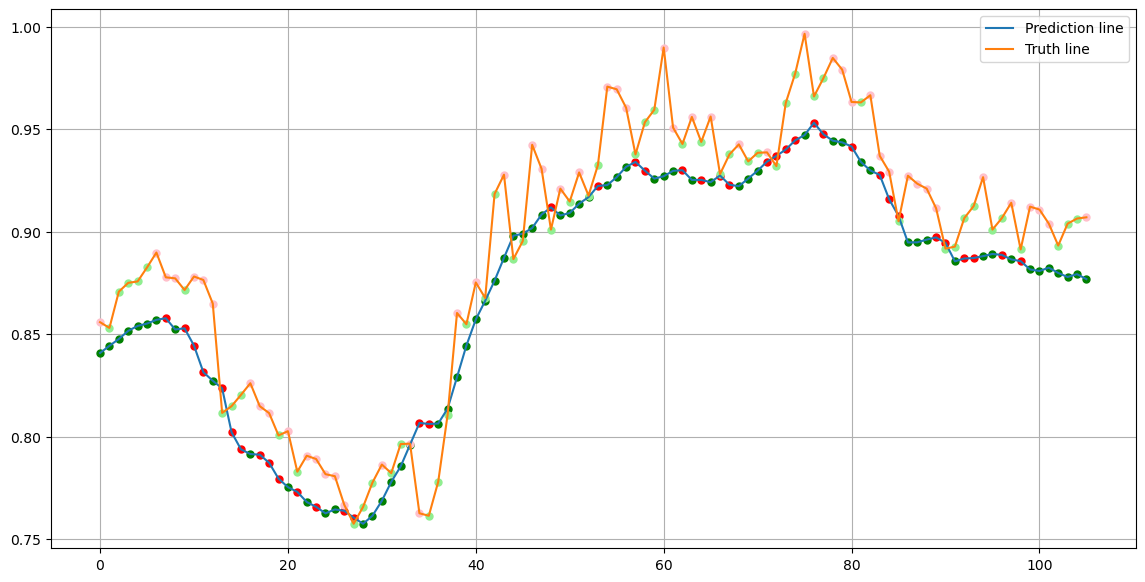

Accuracy for prediction length 2: 51.43%


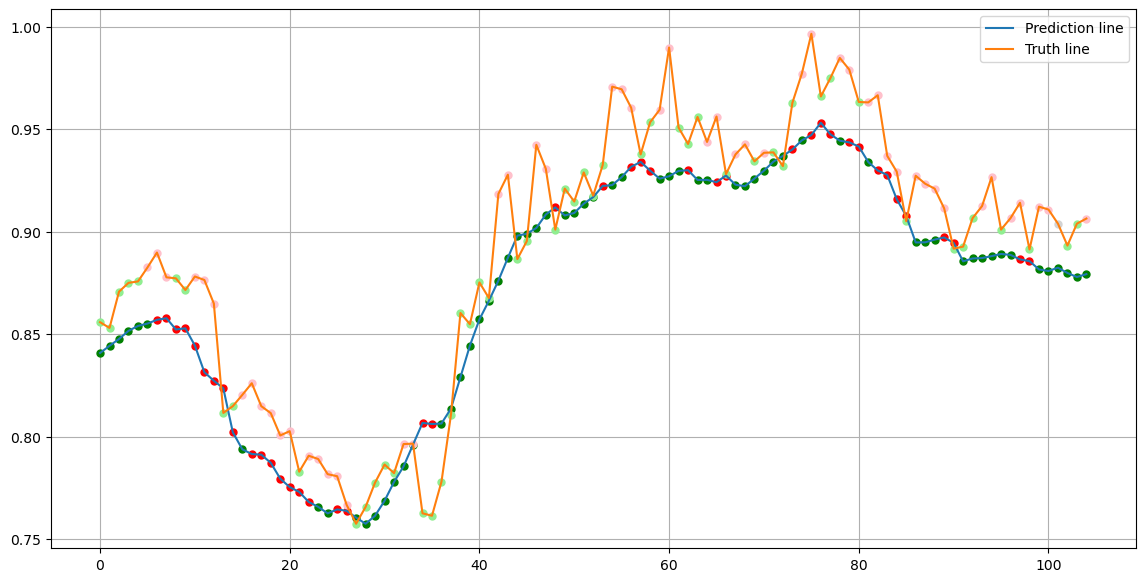

Accuracy for prediction length 3: 68.27%


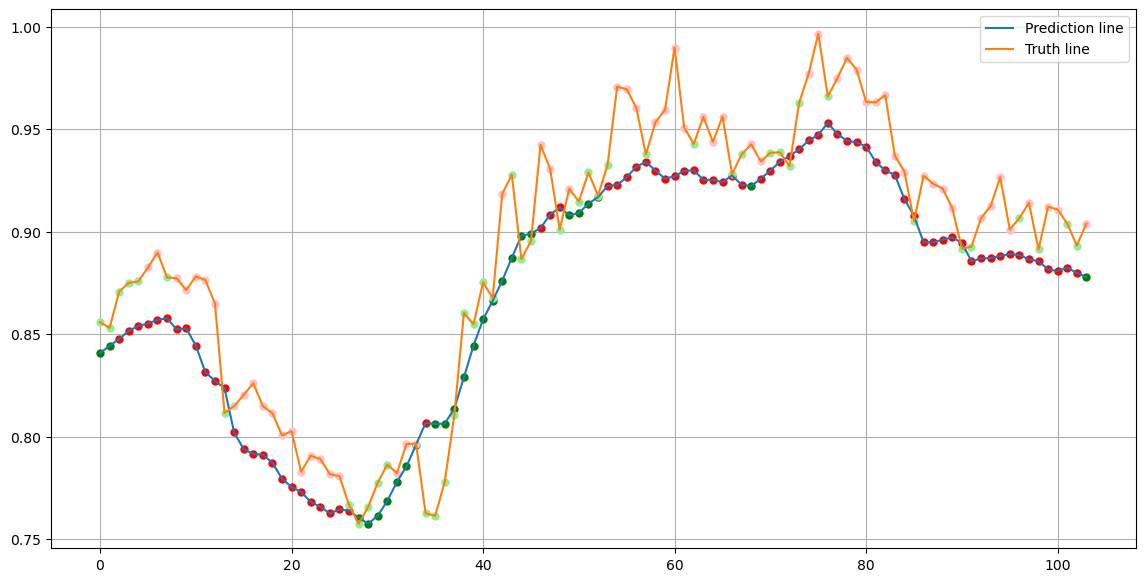

Accuracy for prediction length 4: 70.87%


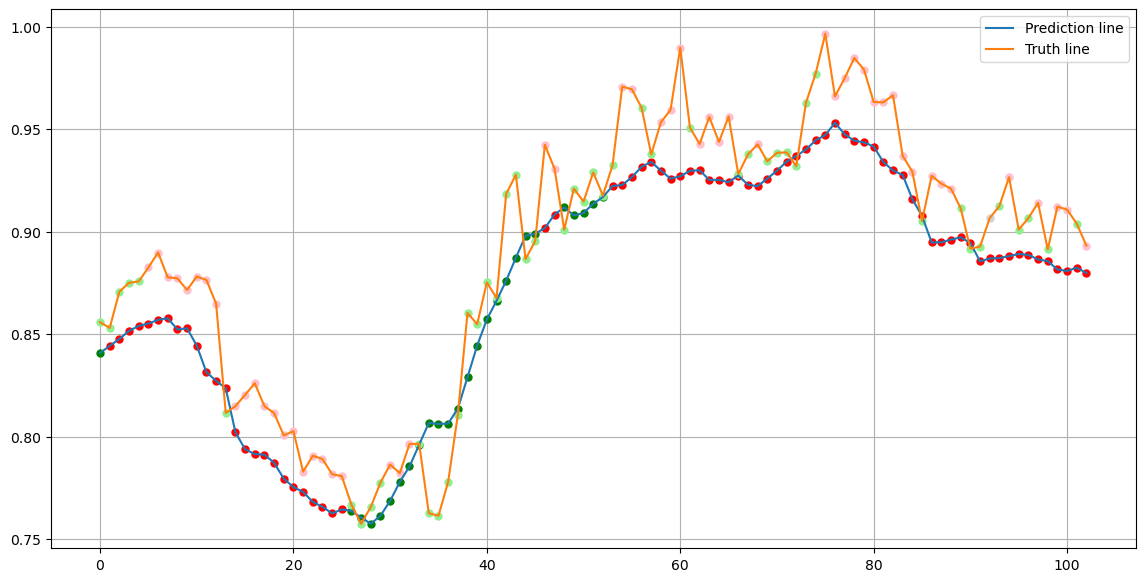

In [13]:
from utils import plot_predictions
plot_predictions(model, device = device,test_X = test_X,test_Y = test_Y)

In [14]:
# plot_predictions(model, device = device,test_X = train_X,test_Y = train_Y)

Accuracy

Starting backtest using backtrader